# Random Forest

## Import pour random forest

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [10]:
me_data = pd.read_csv('./dataset/melb_data.csv')
me_data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [11]:
me_data.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,13580.000000,1.358000e+04,13580.000000,13580.000000,13580.000000,13580.000000,13518.000000,13580.000000,7130.000000,8205.000000,13580.000000,13580.000000,13580.000000
mean,2.937997,1.075684e+06,10.137776,3105.301915,2.914728,1.534242,1.610075,558.416127,151.967650,1964.684217,-37.809203,144.995216,7454.417378
std,0.955748,6.393107e+05,5.868725,90.676964,0.965921,0.691712,0.962634,3990.669241,541.014538,37.273762,0.079260,0.103916,4378.581772
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.182550,144.431810,249.000000
25%,2.000000,6.500000e+05,6.100000,3044.000000,2.000000,1.000000,1.000000,177.000000,93.000000,1940.000000,-37.856822,144.929600,4380.000000
50%,3.000000,9.030000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,440.000000,126.000000,1970.000000,-37.802355,145.000100,6555.000000
75%,3.000000,1.330000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,651.000000,174.000000,1999.000000,-37.756400,145.058305,10331.000000
max,10.000000,9.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,433014.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


## Algo avec la recherche d'hyperparametre (GridSearchCV)

In [14]:
# Imputation des valeurs manquantes
imputer = SimpleImputer(strategy='median')
me_data[me_data.select_dtypes(include=[np.number]).columns] = imputer.fit_transform(me_data.select_dtypes(include=[np.number]))

# Encodage par Target Encoding
if 'Suburb' in me_data.columns:
    suburb_mean_price = me_data.groupby('Suburb')['Price'].mean()
    me_data['Suburb_encoded'] = me_data['Suburb'].map(suburb_mean_price)
    me_data.drop(columns=['Suburb'], inplace=True)

# Création de caractéristiques supplémentaires
me_data['Landsize_squared'] = me_data['Landsize'] ** 2
me_data['BuildingArea_log'] = np.log1p(me_data['BuildingArea'])
me_data['Rooms_Bathroom'] = me_data['Rooms'] * me_data['Bathroom']

# Préparation des données
y = me_data['Price']
fme_features = [
    'Rooms', 'Bathroom', 'Landsize', 'BuildingArea', 'YearBuilt',
    'Lattitude', 'Longtitude', 'Suburb_encoded',
    'Landsize_squared', 'BuildingArea_log', 'Rooms_Bathroom'
]
X = me_data[fme_features]

# Discrétisation de la cible
y_binned = pd.qcut(y, q=5, labels=False)

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Nettoyage des indices invalides
valid_indices = ~pd.isna(y_binned)
X_scaled = X_scaled[valid_indices]
y = y.reset_index(drop=True)[valid_indices]
y_binned = y_binned.reset_index(drop=True)[valid_indices].astype(int)

# Validation des tailles
print(f"X_scaled: {X_scaled.shape}, y: {y.shape}, y_binned: {y_binned.shape}")

# Validation des catégories
print(f"Distribution dans y_binned: \n{y_binned.value_counts()}")

# Paramètres pour GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Modèle Random Forest
model = RandomForestRegressor(random_state=42, n_jobs=-1)

# GridSearchCV avec 5-Fold CV (non stratifié)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,  # 5-fold CV standard
    verbose=1,
    n_jobs=-1
)

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entraînement du modèle
grid_search.fit(X_train, y_train)

# Résultats
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Performances
print(f"Best MAE (Positive): {-grid_search.best_score_:.2f}")
preds = best_model.predict(X_test)
mae_final = mean_absolute_error(y_test, preds)
print(f"Final Mean Absolute Error on test data: {mae_final:.2f}")


X_scaled: (13580, 11), y: (13580,), y_binned: (13580,)
Distribution dans y_binned: 
Price
0    2762
3    2725
1    2717
4    2697
2    2679
Name: count, dtype: int64
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best MAE (Positive): 176681.39
Final Mean Absolute Error on test data: 170541.41


## Algo avec les hyperparametres les plus opti

In [16]:
# Imputation des valeurs manquantes
imputer = SimpleImputer(strategy='median')
me_data[me_data.select_dtypes(include=[np.number]).columns] = imputer.fit_transform(me_data.select_dtypes(include=[np.number]))

# Encoder les colonnes catégoriques via Target Encoding
if 'Suburb' in me_data.columns:
    suburb_mean_price = me_data.groupby('Suburb')['Price'].mean()
    me_data['Suburb_encoded'] = me_data['Suburb'].map(suburb_mean_price)
    me_data.drop(columns=['Suburb'], inplace=True)

# Créer des caractéristiques supplémentaires
me_data['Landsize_squared'] = me_data['Landsize'] ** 2
me_data['BuildingArea_log'] = np.log1p(me_data['BuildingArea'])
me_data['Rooms_Bathroom'] = me_data['Rooms'] * me_data['Bathroom']

# Sélectionner les caractéristiques importantes et la cible
y = me_data['Price']
fme_features = [
    'Suburb_encoded', 'Rooms', 'Longtitude', 'Lattitude', 
    'Landsize_squared', 'Landsize', 'Rooms_Bathroom',
    'YearBuilt', 'BuildingArea_log', 'BuildingArea', 'Bathroom', 'Postcode', 'Bedroom2', 'Distance'
]

X = me_data[fme_features]

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entraîner le modèle avec les meilleurs paramètres
best_params = {'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
model = RandomForestRegressor(**best_params)
model.fit(X_train, y_train)

# Prédictions et évaluation
preds = model.predict(X_test)
mae_final = mean_absolute_error(y_test, preds)
print("Final Mean Absolute Error:", mae_final)

Final Mean Absolute Error: 167511.01168322717


# Gradiant boosting

## Import

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
import optuna
from sklearn.discriminant_analysis import StandardScaler


c:\Users\Skayne\Desktop\cours_tech\Machine learning\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fonction utiles

### dbscan (supprimer les outliner)

In [18]:
def dbscan_func(X, y):

    # Étape 1 : Standardiser les données
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Étape 2 : Appliquer DBSCAN
    dbscan = DBSCAN(eps=1, min_samples=5)  # Ajustez eps et min_samples si nécessaire
    clusters = dbscan.fit_predict(X_scaled)

    X = X.copy()
    X['Cluster'] = clusters
    y = y.reset_index(drop=True)  # Reset index to align X and y
    X['Target'] = y  # Add target variable to the DataFrame

    # Ajouter les clusters aux données
    X['Cluster'] = clusters
    y = y.reset_index(drop=True)  # Réinitialisation de l'index pour aligner X et y
    X['Target'] = y  # Ajouter y dans le DataFrame pour faciliter le filtrage

    # Étape 3 : Filtrer et supprimer les valeurs extrêmes
    filtered_data = X[X['Cluster'] != -1]  # Conserver uniquement les points qui ne sont pas des outliers
    filtered_X = filtered_data.drop(['Cluster', 'Target'], axis=1)  # Supprimer les colonnes auxiliaires
    filtered_y = filtered_data['Target']  # Cible sans outliers

    # Résultat après suppression
    print(f"Nombre de valeurs extrêmes supprimées : {len(X) - len(filtered_X)}")
    print(f"Données restantes après suppression : {len(filtered_X)}")

    return filtered_X, filtered_y

### Trouver les meilleurs paramètres avec optuna

In [19]:
def get_best_params(model_class, param_distributions, X_train, y_train, n_trials=100, scoring='neg_mean_absolute_error', cv=3):
    """
    Optimise les hyperparamètres d'un modèle en utilisant Optuna.
    
    Args:
        model_class (class): Classe du modèle (par exemple, RandomForestRegressor, XGBRegressor, etc.).
        param_distributions (dict): Dictionnaire des distributions de recherche pour les hyperparamètres.
        X_train (pd.DataFrame or np.ndarray): Données d'entraînement (features).
        y_train (pd.Series or np.ndarray): Données d'entraînement (target).
        n_trials (int): Nombre d'essais pour l'optimisation.
        scoring (str): Métrique d'évaluation (compatible avec scikit-learn).
        cv (int): Nombre de plis pour la validation croisée.
    
    Returns:
        dict: Meilleurs hyperparamètres trouvés par Optuna.
    """
    
    def objective(trial):
        # Générer les hyperparamètres pour le modèle
        params = {
            key: _suggest_from_trial(trial, key, dist)
            for key, dist in param_distributions.items()
        }
        
        # Instancier le modèle avec les hyperparamètres suggérés
        model = model_class(**params)
        
        # Validation croisée
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
        
        # Retourner le score moyen (négatif car on minimise)
        return -scores.mean()
    
    # Lancer l'étude Optuna
    optuna.logging.set_verbosity(optuna.logging.INFO)
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    
    # Afficher et retourner les meilleurs hyperparamètres
    print(f"Best trial: {study.best_trial.params}")
    print("Best parameters:", study.best_params)
    print("Best score:", study.best_value)
    return study.best_params


def _suggest_from_trial(trial, name, dist):
    """
    Génère une valeur pour un hyperparamètre à partir de sa distribution spécifiée.
    
    Args:
        trial (optuna.trial.Trial): Instance d'un essai Optuna.
        name (str): Nom de l'hyperparamètre.
        dist (tuple): Distribution de l'hyperparamètre sous la forme (type, params).
    
    Returns:
        float or int or str: Valeur générée pour l'hyperparamètre.
    """
    dist_type, *dist_params = dist
    if dist_type == 'int':
        return trial.suggest_int(name, *dist_params)
    elif dist_type == 'float':
        return trial.suggest_float(name, *dist_params)
    elif dist_type == 'categorical':
        return trial.suggest_categorical(name, dist_params[0])
    else:
        raise ValueError(f"Unsupported distribution type: {dist_type}")


## Importation de la data

In [20]:
# Charger les données
me_file_path = './dataset/melb_data.csv'
me_data = pd.read_csv(me_file_path)

In [21]:
me_data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


## Transformation des datas

In [22]:
# Imputation des valeurs manquantes
imputer = SimpleImputer(strategy='median')
me_data[me_data.select_dtypes(include=[np.number]).columns] = imputer.fit_transform(me_data.select_dtypes(include=[np.number]))

In [23]:
# Encoder les colonnes catégoriques via Target Encoding
if 'Suburb' in me_data.columns:
    suburb_mean_price = me_data.groupby('Suburb')['Price'].mean()
    me_data['Suburb_encoded'] = me_data['Suburb'].map(suburb_mean_price)
    me_data.drop(columns=['Suburb'], inplace=True)

In [24]:
# Créer des caractéristiques supplémentaires
me_data['Landsize_squared'] = me_data['Landsize'] ** 2
me_data['BuildingArea_log'] = np.log1p(me_data['BuildingArea'])
me_data['Rooms_Bathroom'] = me_data['Rooms'] * me_data['Bathroom']

In [25]:
# Sélectionner les caractéristiques et la cible
y = me_data['Price']
fme_features = [
    'Suburb_encoded', 'Rooms', 'Longtitude', 'Lattitude', 
    'Landsize_squared', 'Landsize', 'Rooms_Bathroom',
    'YearBuilt', 'BuildingArea_log', 'BuildingArea', 'Bathroom', 'Postcode', 'Bedroom2', 'Distance'
]
X = me_data[fme_features]

## Machine learning

### Split des datas

In [26]:
filtered_X, filtered_y = dbscan_func(X, y)

# Diviser les données
X_train, X_val, y_train, y_val = train_test_split(filtered_X, filtered_y, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy="mean")  # ou "median"
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)

Nombre de valeurs extrêmes supprimées : 1615
Données restantes après suppression : 11965


### Xtreme Gradiant Boosting (XGBoost)

In [27]:
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

param_distributions_xgb = {
    'n_estimators': ('int', 100, 3000),         # Nombre d'arbres
    'max_depth': ('int', 0, 2),               # Profondeur maximale de l'arbre
    'learning_rate': ('float', 0.01, 0.3),     # Taux d'apprentissage
    'subsample': ('float', 0.5, 1.0),          # Fraction d'échantillons pour chaque arbre
    'colsample_bytree': ('float', 0.5, 1.0),   # Fraction de colonnes utilisées par arbre
    'gamma': ('float', 0, 5),                  # Minimum perte de réduction pour diviser un noeud
    'reg_alpha': ('float', 0, 1),              # Régularisation L1
    'reg_lambda': ('float', 0, 1),             # Régularisation L2
}

best_params_xgb = get_best_params(XGBRegressor, param_distributions_xgb, X_train, y_train, n_trials=25)

# Création du modèle avec les meilleurs hyperparamètres
my_model = XGBRegressor(**best_params_xgb)

# Entraînement du modèle
my_model.fit(X_train, y_train)

# Prédictions sur l'ensemble de validation
predictions = my_model.predict(X_val)

# Calcul de l'erreur absolue moyenne
mae = mean_absolute_error(y_val, predictions)
print(f"Mean Absolute Error: {mae}")

[I 2024-12-18 10:28:45,378] A new study created in memory with name: no-name-b017930c-3894-43d7-b752-f16f8d0d4b74
[I 2024-12-18 10:28:46,394] Trial 0 finished with value: 216837.83086881382 and parameters: {'n_estimators': 1168, 'max_depth': 1, 'learning_rate': 0.17576365294428153, 'subsample': 0.8987145490194113, 'colsample_bytree': 0.9103760279927018, 'gamma': 2.3790058643716816, 'reg_alpha': 0.44375343170838977, 'reg_lambda': 0.060310676937071483}. Best is trial 0 with value: 216837.83086881382.
[I 2024-12-18 10:28:46,927] Trial 1 finished with value: 220660.76451992439 and parameters: {'n_estimators': 476, 'max_depth': 1, 'learning_rate': 0.038473548307553784, 'subsample': 0.9591923885765731, 'colsample_bytree': 0.771078303451747, 'gamma': 4.352601130459397, 'reg_alpha': 0.16779186371652088, 'reg_lambda': 0.4745667529462255}. Best is trial 0 with value: 216837.83086881382.
[I 2024-12-18 10:28:47,757] Trial 2 finished with value: 176232.5354136761 and parameters: {'n_estimators': 89

Best trial: {'n_estimators': 769, 'max_depth': 0, 'learning_rate': 0.02006132156383537, 'subsample': 0.5772368566099072, 'colsample_bytree': 0.6937432826906642, 'gamma': 1.4246519874722143, 'reg_alpha': 0.9532991892776072, 'reg_lambda': 0.5727141195805051}
Best parameters: {'n_estimators': 769, 'max_depth': 0, 'learning_rate': 0.02006132156383537, 'subsample': 0.5772368566099072, 'colsample_bytree': 0.6937432826906642, 'gamma': 1.4246519874722143, 'reg_alpha': 0.9532991892776072, 'reg_lambda': 0.5727141195805051}
Best score: 158327.35254815067
Mean Absolute Error: 152542.88177105098


### Lightgbm

In [28]:
from lightgbm import LGBMRegressor

In [29]:
param_distributions_lgbm = {
    'n_estimators': ('int', 900, 3000),        # Nombre d'arbres
    'max_depth': ('int', 0, 1000000),                         # Profondeur maximale de l'arbre
    'learning_rate': ('float', 0.01, 0.3),     # Taux d'apprentissage
    'subsample': ('float', 0.5, 1.0),          # Fraction d'échantillons pour chaque arbre
    'colsample_bytree': ('float', 0.5, 1.0),   # Fraction de colonnes utilisées par arbre
    'reg_alpha': ('float', 0, 1),              # Régularisation L1
    'reg_lambda': ('float', 0, 1),             # Régularisation L2
    'min_child_samples': ('int', 0, 50),
    'num_leaves': ('int', 100, 1000),
}

best_params_lgbm = get_best_params(LGBMRegressor, param_distributions_lgbm, X_train, y_train, n_trials=25)

mod = LGBMRegressor(**best_params_lgbm)
mod.fit(X_train, y_train)
pred = mod.predict(X_val)
print("Mean Absolute Error: " + str(mean_absolute_error(pred, y_val)))

[I 2024-12-18 11:13:18,417] A new study created in memory with name: no-name-e147a188-14f9-4b72-9c55-82ef91a69fcf
[I 2024-12-18 11:13:39,264] Trial 0 finished with value: 180654.84331585342 and parameters: {'n_estimators': 1957, 'max_depth': 495520, 'learning_rate': 0.19275791510619478, 'subsample': 0.6610903629309399, 'colsample_bytree': 0.7551049727471804, 'reg_alpha': 0.5341955693019002, 'reg_lambda': 0.35431555606894594, 'min_child_samples': 48, 'num_leaves': 502}. Best is trial 0 with value: 180654.84331585342.
[I 2024-12-18 11:14:20,239] Trial 1 finished with value: 176383.18606942488 and parameters: {'n_estimators': 2620, 'max_depth': 951210, 'learning_rate': 0.29756211125804494, 'subsample': 0.7245402779334911, 'colsample_bytree': 0.892223141694475, 'reg_alpha': 0.9433740053921325, 'reg_lambda': 0.24459990337601034, 'min_child_samples': 13, 'num_leaves': 985}. Best is trial 1 with value: 176383.18606942488.
[I 2024-12-18 11:14:54,093] Trial 2 finished with value: 175891.7658371

Best trial: {'n_estimators': 901, 'max_depth': 935332, 'learning_rate': 0.015788375007645208, 'subsample': 0.9030276472007709, 'colsample_bytree': 0.9856672460407698, 'reg_alpha': 0.19264877959294713, 'reg_lambda': 0.7701594707510864, 'min_child_samples': 0, 'num_leaves': 109}
Best parameters: {'n_estimators': 901, 'max_depth': 935332, 'learning_rate': 0.015788375007645208, 'subsample': 0.9030276472007709, 'colsample_bytree': 0.9856672460407698, 'reg_alpha': 0.19264877959294713, 'reg_lambda': 0.7701594707510864, 'min_child_samples': 0, 'num_leaves': 109}
Best score: 157800.00653219264
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2206
[LightGBM] [Info] Number of data points in the train set: 9572, number of used features: 14
[LightGBM] [Info] Start training from score 1029566.358441
Mean Absolute Error: 152242.94560486072


### Combinaison de model

In [30]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Modèle Random Forest
best_params_rf = {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}
rf = RandomForestRegressor(**best_params_rf)

# Modèle XGBoost
gb = XGBRegressor(**best_params_xgb)

# Modèle LightGBM
lgbm = LGBMRegressor(**best_params_lgbm)

# Meta-modèle
meta_model = Ridge()

# Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=[('rf', rf), ('gb', gb), ('lgbm', lgbm)],
    final_estimator=meta_model
)

# Ajustement du modèle
stacking_regressor.fit(X_train, y_train)

# Prédictions
y_pred = stacking_regressor.predict(X_val)

# Évaluation
print("Mean Absolute Error: " + str(mean_absolute_error(y_val, y_pred)))
print("MSE:", mean_squared_error(y_val, y_pred))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2206
[LightGBM] [Info] Number of data points in the train set: 9572, number of used features: 14
[LightGBM] [Info] Start training from score 1029566.358441
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2194
[LightGBM] [Info] Number of data points in the train set: 7657, number of used features: 14
[LightGBM] [Info] Start training from score 1028779.107875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2187
[LightGBM] [Info] Number of data points in the train set: 7657, number of used features: 14
[LightGBM] [Info] 

# Traitement Texte

## Import

In [31]:
# Importer les bibliothèques nécessaires
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import numpy as np
from scipy.sparse import hstack

## Data

In [32]:
spam_emails = [
    "Gagnez 1000 euros maintenant en cliquant ici",
    "Offre spéciale, ne manquez pas cette chance exclusive !",
    "Vous avez été sélectionné pour un prix incroyable",
    "Faites vite ! Cette offre expire bientôt, cliquez ici",
    "Obtenez votre prêt personnel sans vérification de crédit",
    "Profitez d'une réduction de 50% sur tous nos produits",
    "Cliquez ici pour recevoir une carte-cadeau gratuite",
    "Votre compte a été suspendu, veuillez vérifier vos informations",
    "Obtenez un iPhone gratuit maintenant en répondant à ce sondage",
    "Vous êtes le gagnant d'un voyage tout compris, contactez-nous",
    "Ne ratez pas cette opportunité de devenir riche rapidement",
    "Remportez un chèque de 5000 euros en vous inscrivant ici",
    "Vos gains sont prêts à être transférés, entrez vos coordonnées",
    "Dernière chance pour bénéficier de cette offre incroyable",
    "Votre solde a été mis à jour, consultez-le maintenant",
    "Réclamez votre remboursement immédiat en cliquant sur ce lien",
    "Votre compte PayPal a été compromis, réinitialisez votre mot de passe",
    "Vous êtes notre gagnant, confirmez votre identité pour recevoir votre prix",
    "Ne manquez pas cette offre exclusive pour les membres VIP",
    "Inscrivez-vous pour obtenir des échantillons gratuits de nos produits",
    "Gagnez un week-end tout inclus en répondant à ce sondage rapide",
    "Vous avez droit à un remboursement exceptionnel, cliquez ici",
    "Recevez une carte-cadeau Amazon de 100 euros maintenant",
    "Offre exclusive pour un prêt à taux zéro, approuvé instantanément",
    "Obtenez une réduction immédiate en utilisant ce code promo",
    "Votre colis est en attente, confirmez votre adresse maintenant",
    "Votre abonnement a été renouvelé, vérifiez les détails ici",
    "Vous êtes sélectionné pour notre nouvelle promotion, cliquez pour plus de détails",
    "Profitez de 70% de réduction aujourd'hui seulement, n'attendez pas !",
    "Félicitations, vous avez gagné une carte-cadeau de 500 euros",
    "Participez à notre concours pour remporter une voiture neuve",
    "Cette offre expire ce soir, cliquez maintenant pour en bénéficier",
    "Votre remboursement est en attente, confirmez vos informations",
    "Cliquez ici pour recevoir un bonus exclusif sur votre prochain achat",
    "Votre compte bancaire a été suspendu, veuillez réinitialiser votre mot de passe",
    "Votre carte de crédit est sur le point d'expirer, mettez-la à jour ici",
    "Obtenez un prêt immédiat sans justificatif en quelques clics",
    "Vous êtes qualifié pour recevoir un prêt personnel à taux réduit",
    "Confirmez votre adresse pour recevoir un iPhone 12 gratuit",
    "Votre compte est sur le point d'être fermé, action requise",
    "Réclamez vos gains de loterie non réclamés, agissez vite",
    "Votre abonnement Netflix a été suspendu, mettez à jour vos informations",
    "Félicitations ! Vous êtes le gagnant d'un voyage de luxe",
    "Recevez un iPad gratuit en répondant à notre enquête",
    "Votre compte a été sélectionné pour une récompense spéciale",
    "Participez maintenant pour gagner une voiture de sport",
    "Obtenez une remise instantanée sur tous vos achats avec ce lien",
    "Vos informations de carte bancaire sont obsolètes, mettez-les à jour ici",
    "Obtenez une réduction de 70% en utilisant ce code promo exclusif",
    "Votre accès au site premium a été suspendu, réactivez-le maintenant",
    "Vous êtes sélectionné pour gagner une somme d'argent importante",
    "Gagnez 10 000 € dès aujourd'hui sans effort ! Cliquez ici.",
    "Vous avez été sélectionné pour une récompense exclusive. Répondez vite !",
    "Travaillez depuis chez vous et gagnez jusqu'à 5000 € par mois.",
    "Votre compte bancaire a été suspendu. Cliquez ici pour le réactiver.",
    "Félicitations ! Vous avez gagné un iPhone 14 Pro. Répondez dans les 24 heures.",
    "Perdez 10 kilos en seulement 2 semaines ! Découvrez notre solution miracle.",
    "Dernière chance pour profiter de notre offre exceptionnelle : 90% de réduction.",
    "Votre colis ne peut pas être livré. Confirmez vos informations ici.",
    "Investissez dans les cryptomonnaies et multipliez vos gains par 10.",
    "Urgent : Votre carte de crédit a été bloquée. Vérifiez vos informations.",
    "Devenez riche rapidement grâce à notre système infaillible !",
    "Réclamez vos gains maintenant ! Vous êtes l'heureux gagnant de 1 000 000 €.",
    "Alerte de sécurité : accès non autorisé détecté. Confirmez votre mot de passe.",
    "Obtenez des médicaments à des prix incroyablement bas. Commandez maintenant.",
    "Notre produit révolutionnaire vous fera repousser vos cheveux en 30 jours.",
    "Besoin de financement ? Obtenez un prêt immédiat sans vérification.",
    "Votre abonnement Netflix expire bientôt. Renouvelez-le ici.",
    "Votre compte PayPal a été restreint. Connectez-vous pour résoudre le problème.",
    "Rencontrez des célibataires près de chez vous dès aujourd'hui !",
    "Logiciel espion détecté sur votre appareil. Téléchargez notre solution antivirus.",
    "Accédez aux secrets pour devenir millionnaire. Inscrivez-vous gratuitement !",
    "Vous êtes notre gagnant du jour ! Ne manquez pas cette opportunité.",
    "Profitez de notre offre spéciale : 2 produits achetés, 3 gratuits.",
    "Attention : Votre compte e-mail est sur le point d'être supprimé.",
    "Investissez 250 € et gagnez jusqu'à 10 000 € par semaine.",
    "Cliquez ici pour récupérer votre lot de 5000 € offert par notre partenaire.",
    "Solution anti-âge miracle : retrouvez votre jeunesse en 15 jours !",
    "Annonce exclusive : devenez propriétaire sans apport personnel.",
    "Votre ordinateur est infecté ! Téléchargez notre antivirus pour résoudre le problème.",
    "Faites fructifier vos économies grâce à notre programme d'investissement.",
    "Gagnez une carte-cadeau Amazon de 500 €. Cliquez ici pour participer.",
    "Découvrez les secrets pour perdre du poids sans effort.",
    "Transfert d'argent instantané : gagnez 1000 € en quelques clics.",
    "Votre assurance automobile expire bientôt. Renouvelez ici pour économiser.",
    "Recevez votre héritage de 1 000 000 €. Contactez-nous rapidement.",
    "Offre exclusive : obtenez un prêt à 0% d'intérêt immédiatement.",
    "Votre mot de passe a expiré. Cliquez ici pour le réinitialiser.",
    "Réservez vos vacances de rêve à moitié prix dès maintenant !",
    "Vous avez une nouvelle facture en attente. Consultez-la ici.",
    "Gagnez des bonus exceptionnels en parrainant vos amis !",
    "Recevez votre paiement instantané grâce à notre programme d'affiliation.",
    "Faites-vous plaisir : 70% de réduction sur tous nos produits en ligne.",
    "Urgent : mise à jour de vos informations requise pour éviter la suppression.",
    "Trouvez l'amour de votre vie aujourd'hui grâce à notre site de rencontre.",
    "Votre PC est lent ? Boostez-le avec notre outil d'optimisation gratuit.",
    "Profitez d'une assurance santé premium à partir de 10 € par mois.",
    "Nous vous offrons une carte-cadeau Carrefour de 100 €. Cliquez pour en profiter.",
    "Devenez trader professionnel en quelques jours avec notre formation gratuite.",
    "Recevez des gains incroyables grâce à notre plateforme de trading automatisé.",
    "Participez à notre enquête et recevez un bon d'achat de 20 €.",
    "Gagnez 10 000 € en une semaine grâce à notre méthode secrète !",
    "Votre compte a été piraté, cliquez ici pour le récupérer immédiatement.",
    "Recevez un iPhone 14 gratuitement ! Offre limitée, inscrivez-vous maintenant.",
    "Cher utilisateur, vos informations bancaires sont incomplètes. Veuillez les mettre à jour ici.",
    "Profitez de 70 % de réduction sur nos produits miracles pour perdre du poids.",
    "Vous avez gagné un voyage de rêve ! Cliquez pour réclamer votre prix.",
    "Notre société vous propose des crédits sans vérification, obtenez de l'argent rapidement.",
    "Alerte : votre abonnement expire bientôt. Renouvelez-le ici pour éviter la perte de vos données.",
    "Découvrez comment gagner 5 000 € par mois depuis chez vous, sans effort.",
    "Achetez nos montres de luxe pour seulement 20 €, édition spéciale !",
    "Cliquez ici pour recevoir une carte cadeau Amazon de 100 € gratuitement.",
    "Votre colis est bloqué. Cliquez sur ce lien pour payer les frais d'expédition.",
    "Nouvelle opportunité d'investissement : multipliez vos revenus par 10 !",
    "Faites fortune grâce au trading en ligne avec notre plateforme exclusive.",
    "Offre incroyable : recevez 50 % de cashback sur toutes vos transactions.",
    "Votre ordinateur est infecté par des virus dangereux. Cliquez pour nettoyer votre système.",
    "Félicitations ! Vous avez été sélectionné pour participer à notre jeu concours.",
    "Recevez votre crédit instantanément sans justificatif, demandez maintenant.",
    "Perdez 10 kilos en 15 jours grâce à notre pilule révolutionnaire.",
    "Vous êtes notre client chanceux du jour ! Gagnez une voiture en répondant à ce mail.",
    "Récupérez vos gains immédiatement en confirmant vos coordonnées bancaires ici.",
    "Rejoignez notre programme exclusif pour devenir riche en 30 jours.",
    "Avertissement : votre compte sera suspendu si vous ne confirmez pas vos informations.",
    "Profitez d'une assurance auto gratuite pendant 3 mois, inscrivez-vous ici.",
    "Cliquez ici pour profiter de nos médicaments génériques à prix imbattables.",
    "Obtenez un prêt personnel avec un taux d'intérêt de 0 %. Demandez aujourd'hui !",
    "Vous avez un nouveau message vocal non lu, écoutez-le en cliquant sur ce lien.",
    "Achetez nos lunettes de soleil de marque à seulement 9,99 € pendant 24h !",
    "Votre carte de fidélité a été sélectionnée pour des récompenses exceptionnelles.",
    "Obtenez vos crypto-monnaies gratuitement, inscrivez-vous dès maintenant.",
    "Votre adresse e-mail a gagné un prix exceptionnel. Réclamez-le en cliquant ici.",
    "Alerte sécurité : une activité suspecte a été détectée sur votre compte.",
    "Votre héritage est prêt à être transféré. Contactez-nous pour les démarches.",
    "Dernière chance : rejoignez notre programme pour devenir millionnaire.",
    "Votre compte PayPal a été limité. Veuillez vérifier votre identité.",
    "Augmentez vos performances avec nos compléments alimentaires naturels.",
    "Obtenez un crédit renouvelable sans aucune vérification en 24h.",
    "Le secret pour une peau jeune et sans rides se trouve ici.",
    "Travaillez depuis chez vous et gagnez jusqu'à 2 000 € par semaine.",
    "Votre facture impayée doit être réglée immédiatement. Cliquez pour en savoir plus.",
    "Félicitations ! Vous êtes le gagnant de notre grand tirage au sort.",
    "Recevez nos e-books gratuits pour apprendre comment devenir riche.",
    "Votre numéro a été tiré au sort pour remporter un chèque de 500 €.",
    "Régularisez votre situation fiscale en cliquant ici, offre limitée.",
    "Profitez de nos crédits à taux zéro, sans justificatifs requis.",
    "Achetez deux produits, recevez-en trois gratuitement ! Offre flash.",
    "Vos informations de carte de crédit doivent être vérifiées immédiatement.",
    "Inscrivez-vous pour découvrir comment doubler vos gains en ligne.",
    "Nous garantissons la livraison d'une montre Rolex à seulement 99 €. Saisissez l'offre !",
    "Cliquez ici pour découvrir le programme minceur recommandé par les célébrités.",
    "Rendez votre voiture électrique pour seulement 50 €, commandez maintenant !",
    "Dernier rappel : gagnez 1 000 € en répondant simplement à notre questionnaire."
]

non_spam_emails = [
    "Réunion prévue demain à 9h, merci de confirmer votre présence",
    "N'oubliez pas de soumettre votre rapport avant vendredi",
    "Votre commande a été expédiée, vous la recevrez sous 3 jours",
    "Confirmation de votre réservation pour le dîner de ce soir",
    "Le projet avance bien, nous aurons une réunion la semaine prochaine",
    "Merci pour votre inscription à notre newsletter",
    "La facture de votre abonnement est disponible dans votre espace client",
    "Votre compte a été activé avec succès, bienvenue parmi nous",
    "Nous avons bien reçu votre demande, elle est en cours de traitement",
    "L'événement commence à 18h, veuillez arriver 15 minutes à l'avance",
    "Votre rendez-vous médical est confirmé pour le 10 octobre",
    "Merci pour votre participation à notre sondage",
    "Votre dossier a été approuvé, vous recevrez une confirmation sous peu",
    "Le contrat est prêt à être signé, merci de passer au bureau",
    "Votre demande de remboursement a été acceptée",
    "Nous avons mis à jour notre politique de confidentialité",
    "N'oubliez pas de renouveler votre abonnement avant la fin du mois",
    "Merci pour votre achat, votre facture est disponible en pièce jointe",
    "Votre compte est sécurisé, aucun changement détecté",
    "Nous vous informons d'une interruption de service prévue ce weekend",
    "Votre colis est en chemin, suivez son parcours ici",
    "Merci pour votre soutien lors de la dernière réunion",
    "Le projet a été approuvé par la direction, nous avançons sur la suite",
    "Le planning de la semaine prochaine est disponible en ligne",
    "Merci de nous avoir contactés, nous vous répondrons sous 48h",
    "Votre rendez-vous chez le médecin a été reporté à une date ultérieure",
    "L'ordre du jour de la réunion vous sera envoyé demain",
    "Votre participation à l'événement a bien été enregistrée",
    "Les tickets pour le concert sont maintenant disponibles",
    "Votre facture est en attente de paiement, merci de régulariser",
    "Le rapport mensuel sera disponible la semaine prochaine",
    "N'oubliez pas de vérifier les détails de votre contrat avant signature",
    "Votre compte a été mis à jour avec succès",
    "Veuillez confirmer votre adresse pour l'envoi de votre commande",
    "La mise à jour de sécurité est désormais disponible",
    "Merci de mettre à jour vos informations de compte",
    "Nous avons bien reçu votre retour de produit, il est en traitement",
    "Votre rendez-vous chez le dentiste est confirmé",
    "Merci pour votre retour d'expérience, nous en tiendrons compte",
    "La réunion d'équipe est reportée à la semaine prochaine",
    "Votre espace client a été mis à jour, consultez-le ici",
    "Merci de compléter le formulaire avant la fin du mois",
    "Le nouveau catalogue est disponible, consultez-le en ligne",
    "Votre inscription à la formation a bien été validée",
    "Nous avons bien reçu votre demande de remboursement",
    "Votre commande a été annulée à votre demande",
    "Merci pour votre participation à l'enquête, les résultats sont disponibles",
    "Le webinaire commencera à 14h, merci de vous connecter 5 minutes avant",
    "Votre changement de mot de passe a été effectué avec succès",
    "L'événement est prévu pour le 15 octobre, inscrivez-vous rapidement",
    "Votre colis est arrivé au point de retrait, vous pouvez le récupérer",
    "Bonjour, pouvez-vous me confirmer la date de notre prochaine réunion ?",
    "Cher(e) client(e), votre facture du mois de mai est disponible dans votre espace personnel.",
    "Salut ! On se retrouve demain pour le déjeuner à 12h ?",
    "Votre commande a bien été expédiée et sera livrée sous 3 jours.",
    "Rappel : votre rendez-vous médical est prévu le 20 juin à 14h.",
    "Merci pour votre participation à notre dernier sondage. Vos réponses sont précieuses.",
    "Votre abonnement à notre newsletter a bien été confirmé.",
    "Veuillez trouver ci-joint le compte-rendu de la réunion de ce matin.",
    "Bonjour, je vous envoie le devis que vous avez demandé. Merci de me confirmer la réception.",
    "Votre dossier a bien été pris en compte. Nous reviendrons vers vous prochainement.",
    "N'oubliez pas de valider votre inscription pour l'événement de la semaine prochaine.",
    "La bibliothèque vous rappelle que le livre emprunté doit être rendu avant le 30 juin.",
    "Votre billet électronique pour le concert du 15 juillet est en pièce jointe.",
    "Bonjour, pouvez-vous m’envoyer les dernières mises à jour du projet ?",
    "Félicitations ! Votre candidature a été retenue pour la prochaine étape.",
    "Bonjour, voici le lien pour accéder au webinaire prévu aujourd'hui.",
    "Votre remboursement a bien été traité. Vous le recevrez sous 3 jours ouvrables.",
    "L'école vous informe que les cours seront suspendus ce vendredi pour cause de grève.",
    "Invitation : participez à notre atelier sur la gestion du temps ce jeudi.",
    "Bonjour, merci d'avoir passé commande chez nous. Voici un résumé de votre achat.",
    "Votre paiement a bien été reçu. Merci pour votre confiance.",
    "Le service informatique vous informe qu'une maintenance est prévue ce soir à 20h.",
    "Vos résultats d'examen sont disponibles sur votre espace étudiant.",
    "Confirmation de votre réservation : hôtel à Paris du 5 au 8 août.",
    "Veuillez confirmer votre présence pour la cérémonie du 12 septembre.",
    "Salut, peux-tu m'envoyer les photos de notre sortie de samedi dernier ?",
    "Votre demande de congés a été acceptée par la direction.",
    "Cher(e) membre, profitez de nos avantages exclusifs en magasin cette semaine.",
    "Bonjour, je vous rappelle notre rendez-vous de demain à 10h.",
    "Voici la facture de votre dernier achat effectué le 15 mai.",
    "L'offre d'emploi à laquelle vous avez postulé a été mise à jour.",
    "Votre colis est arrivé au point relais. Venez le récupérer dès aujourd'hui.",
    "Le spectacle pour lequel vous avez réservé commence à 20h. N'oubliez pas vos billets !",
    "Nous vous remercions pour votre inscription à notre formation.",
    "Bonjour, voici les nouvelles mises à jour de notre application.",
    "Vous êtes abonné à notre service premium. Voici les dernières nouveautés.",
    "Votre assistance technique est prévue pour demain à 9h.",
    "Merci pour votre message. Nous reviendrons vers vous sous 24 heures.",
    "Salut, as-tu eu le temps de jeter un œil au document que je t'ai envoyé ?",
    "L'association vous invite à sa réunion annuelle le 10 octobre.",
    "Votre relevé bancaire est disponible dans votre espace client.",
    "Confirmation : votre demande de participation à l'atelier a bien été prise en compte.",
    "Bonjour, veuillez trouver ci-joint la dernière version du contrat.",
    "Le prochain cours de yoga aura lieu vendredi à 18h.",
    "Votre véhicule est prêt. Merci de passer en concession pour le récupérer.",
    "Cher(e) utilisateur(trice), nous vous remercions pour votre fidélité.",
    "Rappel : la date limite pour l'envoi des documents est fixée au 28 juin.",
    "Bonjour, le planning de la semaine prochaine est maintenant disponible.",
    "Votre carte de fidélité a été créditée de 100 points supplémentaires.",
    "Je vous confirme la réception de votre e-mail et vous répondrai au plus vite.",
    "Votre abonnement arrive bientôt à expiration. Souhaitez-vous le renouveler ?",
    "Merci d'avoir participé à notre événement ! Voici le résumé des discussions.",
    "Bonjour, je voulais savoir si vous êtes disponible pour une réunion cette semaine ?",
    "Votre reçu de paiement est maintenant disponible dans votre espace client.",
    "Salut, pourrais-tu me donner des nouvelles de ton projet ?",
    "L'entreprise vous remercie pour votre participation à la dernière session de formation.",
    "N'oubliez pas de passer récupérer votre commande au magasin avant le 15 août.",
    "Confirmation : votre réservation de train pour Paris a bien été enregistrée.",
    "Bonjour, je vous envoie le rapport d'analyse demandé la semaine dernière.",
    "Votre livraison est en chemin. Suivez votre colis grâce au lien ci-dessous.",
    "Félicitations, vous avez été sélectionné pour participer à notre prochain atelier.",
    "Rappel : votre entretien est prévu demain à 14h. Merci d'arriver en avance.",
    "Cher client, votre abonnement à notre service premium a été renouvelé.",
    "Je vous transmets la présentation pour notre réunion de demain matin.",
    "Nous vous confirmons que votre contrat a bien été signé électroniquement.",
    "Votre demande de remboursement a été acceptée. Le montant sera crédité sous 5 jours.",
    "Bonjour, le devis demandé a été joint à ce message. Merci de votre retour.",
    "Votre facture pour le mois d'avril est disponible en pièce jointe.",
    "Salut, pourrais-tu m'envoyer ton retour sur le document que je t'ai partagé ?",
    "La bibliothèque vous informe que vos réservations sont prêtes à être récupérées.",
    "Cher(e) élève, vos cours commenceront le lundi 4 septembre à 8h30.",
    "Nous vous remercions pour votre commande et espérons que vous serez satisfait.",
    "Votre dossier a été mis à jour. Consultez les nouvelles informations en ligne.",
    "L'invitation pour notre séminaire annuel vous a été envoyée par courrier.",
    "Votre code d'accès à la plateforme a été réinitialisé avec succès.",
    "Bonjour, je vous confirme notre rendez-vous de ce jeudi à 11h en salle de réunion B.",
    "Votre demande d'inscription à l'événement a été validée.",
    "Merci pour votre message. Je reviendrai vers vous dès que possible.",
    "Votre réunion de ce vendredi a été déplacée à 15h au lieu de 10h.",
    "Cher(e) client(e), votre carte de fidélité expire bientôt. Pensez à la renouveler.",
    "Votre relevé d'activité du mois est disponible dans votre espace personnel.",
    "Le restaurant confirme votre réservation pour 4 personnes le samedi 20 à 20h.",
    "Bonjour, avez-vous des précisions concernant le projet de la semaine prochaine ?",
    "Votre abonnement au journal numérique est actif jusqu'au 31 décembre.",
    "L'école vous informe que les cours reprendront à la date habituelle.",
    "Salut, je te rappelle notre rendez-vous sportif demain à 18h.",
    "La maintenance de votre compte a été réalisée avec succès.",
    "Voici les billets pour le spectacle prévu dimanche prochain à 18h.",
    "Nous vous remercions pour votre engagement et votre soutien constant.",
    "Votre rapport hebdomadaire d'activité est maintenant disponible.",
    "Merci de bien vouloir confirmer votre participation à notre événement caritatif.",
    "Le remboursement pour votre dernière transaction a été effectué.",
    "Votre carte de membre est prête. Venez la chercher à notre guichet principal.",
    "Bonjour, je vous transmets les consignes pour le prochain audit interne.",
    "Votre confirmation d'inscription à la conférence a été envoyée.",
    "Salut, peux-tu m'envoyer les documents nécessaires avant jeudi matin ?",
    "L'administration vous informe que vos documents ont été validés.",
    "Votre mot de passe a bien été réinitialisé. Veuillez le modifier à votre prochaine connexion.",
    "Merci pour votre fidélité ! Découvrez les offres exclusives du mois de septembre.",
    "Nous avons bien reçu votre retour d'information et vous en remercions.",
    "Bonjour, voici le programme détaillé de notre prochaine formation.",
    "Votre rendez-vous avec le conseiller est confirmé pour vendredi à 10h.",
    "Je vous remercie pour votre retour rapide sur ce sujet délicat.",
    "Le centre médical vous confirme votre rendez-vous pour le 10 juillet à 15h.",
    "Votre espace client a été mis à jour avec vos dernières informations."
]

## Normalisation des emails

In [33]:
# Combiner les emails de spam et non-spam
emails = spam_emails + non_spam_emails
labels = [1] * len(spam_emails) + [0] * len(non_spam_emails)  # 1 pour spam, 0 pour non-spam

# Vérification des tailles
print(f"Nombre d'emails: {len(emails)}")
print(f"Nombre d'étiquettes: {len(labels)}")

Nombre d'emails: 309
Nombre d'étiquettes: 309


## Les modèles de ML

### Naive bayes

In [34]:
# Étape 1 : Convertir le texte en vecteurs numériques (Bag of Words)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(emails)
# Vérification des dimensions après transformation
print(f"Dimension de la matrice X : {X.shape[0]} emails et {X.shape[1]} caractéristiques")

Dimension de la matrice X : 309 emails et 793 caractéristiques


In [35]:
# Étape 2 : Diviser le jeu de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [36]:
# Étape 3 : Créer et entraîner le modèle Naïve Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [37]:
# Étape 4 : Prédire sur les données de test
y_pred = model.predict(X_test)

In [38]:
# Étape 5 : Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle : {accuracy:.2f}")

Précision du modèle : 0.98


In [39]:
# Afficher un rapport de classification
print("\nRapport de classification :\n", classification_report(y_test, y_pred))


Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      0.97      0.98        30

    accuracy                           0.98        62
   macro avg       0.98      0.98      0.98        62
weighted avg       0.98      0.98      0.98        62



In [40]:
# Tester une prédiction manuelle
new_email = ["Félicitations, vous avez gagné un iPhone gratuit, cliquez ici pour réclamer"]
new_email_vectorized = vectorizer.transform(new_email)
prediction = model.predict(new_email_vectorized)
print("\nL'email est classifié comme :", "spam" if prediction[0] == 1 else "non-spam")


L'email est classifié comme : spam


### TF-IDF

In [41]:
# Étape 1 : Convertir le texte en vecteurs numériques (TF-IDF)
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(emails)  # Utiliser TF-IDF pour représenter le texte

# Vérification des dimensions après transformation
print(f"Dimension de la matrice TF-IDF : {X_tfidf.shape[0]} emails et {X_tfidf.shape[1]} caractéristiques")


Dimension de la matrice TF-IDF : 309 emails et 793 caractéristiques


In [42]:
# Étape 2 : Convertir le texte en vecteurs numériques (Bag of Words)
vectorizer_bow = CountVectorizer()
X_naiveBayes = vectorizer_bow.fit_transform(emails)  # Utiliser Bag of Words pour représenter le texte

# Vérification des dimensions après transformation
print(f"Dimension de la matrice Bag of Words : {X_naiveBayes.shape[0]} emails et {X_naiveBayes.shape[1]} caractéristiques")

Dimension de la matrice Bag of Words : 309 emails et 793 caractéristiques


In [43]:
# Étape 3 : Combiner les deux représentations (TF-IDF et Bag of Words)
X_combined = hstack([X_tfidf, X_naiveBayes])  # Utiliser hstack pour combiner les matrices sparse

# Vérification de la forme de la matrice combinée
print(f"Dimension de la matrice combinée : {X_combined.shape[0]} emails et {X_combined.shape[1]} caractéristiques")

Dimension de la matrice combinée : 309 emails et 1586 caractéristiques


In [44]:
# Étape 4 : Diviser le jeu de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_combined, labels, test_size=0.2, random_state=42)

In [45]:
# Étape 5 : Créer et entraîner un modèle SVM
model = SVC(kernel='linear')  # Utiliser un noyau linéaire pour SVM
model.fit(X_train, y_train)

SVC(kernel='linear')

In [46]:
# Étape 6 : Prédire sur les données de test
y_pred = model.predict(X_test)

In [47]:
# Étape 7 : Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle SVM : {accuracy:.2f}")

Précision du modèle SVM : 0.94


In [48]:
# Afficher un rapport de classification
print("\nRapport de classification :\n", classification_report(y_test, y_pred))


Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      0.94      0.94        32
           1       0.93      0.93      0.93        30

    accuracy                           0.94        62
   macro avg       0.94      0.94      0.94        62
weighted avg       0.94      0.94      0.94        62



In [49]:
# Étape 8 : Tester une prédiction manuelle
new_email = ["Félicitations, vous avez gagné un iPhone gratuit, cliquez ici pour réclamer"]
new_email_tfidf = vectorizer_tfidf.transform(new_email)
new_email_bow = vectorizer_bow.transform(new_email)
new_email_combined = hstack([new_email_tfidf, new_email_bow])  # Combiner les deux représentations pour la nouvelle prédiction
prediction = model.predict(new_email_combined)
print("\nL'email est classifié comme :", "spam" if prediction[0] == 1 else "non-spam")


L'email est classifié comme : spam


### SVM

In [50]:

# Étape 2 : Diviser le jeu de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Étape 3 : Créer et entraîner le modèle SVM
# model = SVC(kernel='linear')  # Utiliser un noyau linéaire pour SVM

model = SVC(kernel='rbf')  # Utiliser un noyau non linéaire pour SVM
model.fit(X_train, y_train)

# Étape 4 : Prédire sur les données de test
y_pred = model.predict(X_test)

# Étape 5 : Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle SVM : {accuracy:.2f}")

# Afficher un rapport de classification
print("\nRapport de classification :\n", classification_report(y_test, y_pred))

# Tester une prédiction manuelle
new_email = ["Félicitations, vous avez gagné un iPhone gratuit, cliquez ici pour réclamer"]
new_email_vectorized = vectorizer.transform(new_email)
prediction = model.predict(new_email_vectorized)
print("\nL'email est classifié comme :", "spam" if prediction[0] == 1 else "non-spam")


Précision du modèle SVM : 0.92

Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      0.91      0.92        32
           1       0.90      0.93      0.92        30

    accuracy                           0.92        62
   macro avg       0.92      0.92      0.92        62
weighted avg       0.92      0.92      0.92        62


L'email est classifié comme : spam


In [51]:
# Importer les bibliothèques nécessaires
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.naive_bayes import GaussianNB  # Par exemple, GaussianNB pour gérer des données continues
from sklearn.metrics import accuracy_score, classification_report

# Liste d'emails (spam et non-spam) - À remplacer par tes données
# Assurez-vous que `spam_emails` et `non_spam_emails` sont définis
emails = spam_emails + non_spam_emails
labels = [1] * len(spam_emails) + [0] * len(non_spam_emails)  # 1 pour spam, 0 pour non-spam

# Étape 1 : Convertir le texte en vecteurs numériques (TF-IDF)
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(emails).toarray()  # Convertir en tableau dense

# Vérification des dimensions après transformation
print(f"Dimension de la matrice TF-IDF : {X_tfidf.shape[0]} emails et {X_tfidf.shape[1]} caractéristiques")

# Étape 2 : Entraîner un modèle Word2Vec pour générer des embeddings
tokenized_emails = [email.split() for email in emails]  # Tokenisation simple

embedding_dim = 100  # Dimension des embeddings de mots
word2vec_model = Word2Vec(sentences=tokenized_emails, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Fonction pour obtenir la moyenne des embeddings d'un email
def get_word2vec_embedding(email_tokens, model, embedding_dim):
    embeddings = [model.wv[word] for word in email_tokens if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(embedding_dim)

# Créer les embeddings pour chaque email
email_embeddings = np.array([get_word2vec_embedding(email.split(), word2vec_model, embedding_dim) for email in emails])

# Vérification des dimensions après la génération des embeddings
print(f"Dimension de la matrice des embeddings : {email_embeddings.shape}")

# Étape 3 : Combiner TF-IDF et les embeddings de mots Word2Vec
X_combined = np.hstack([X_tfidf, email_embeddings])  # Combiner les matrices denses

# Étape 4 : Diviser le jeu de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_combined, labels, test_size=0.2, random_state=42)

# Étape 5 : Créer et entraîner un modèle Naïve Bayes (par exemple, GaussianNB pour des données continues)
model = GaussianNB()
model.fit(X_train, y_train)

# Étape 6 : Prédire sur les données de test
y_pred = model.predict(X_test)

# Étape 7 : Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle : {accuracy:.2f}")

# Afficher un rapport de classification
print("\nRapport de classification :\n", classification_report(y_test, y_pred))

# Étape 8 : Tester une prédiction manuelle
new_email = ["Félicitations, vous avez gagné un iPhone gratuit, cliquez ici pour réclamer"]
new_email_tfidf = vectorizer.transform(new_email).toarray()
new_email_tokens = new_email[0].split()
new_email_embedding = get_word2vec_embedding(new_email_tokens, word2vec_model, embedding_dim)
new_email_combined = np.hstack([new_email_tfidf, new_email_embedding.reshape(1, -1)])  # Combiner TF-IDF + Embeddings
prediction = model.predict(new_email_combined)
print("\nL'email est classifié comme :", "spam" if prediction[0] == 1 else "non-spam")


Dimension de la matrice TF-IDF : 309 emails et 793 caractéristiques
Dimension de la matrice des embeddings : (309, 100)
Précision du modèle : 0.97

Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        32
           1       0.97      0.97      0.97        30

    accuracy                           0.97        62
   macro avg       0.97      0.97      0.97        62
weighted avg       0.97      0.97      0.97        62


L'email est classifié comme : spam


In [52]:
# Importer les bibliothèques nécessaires
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # SVM pour la classification
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec
from scipy.sparse import hstack

# Liste d'emails (spam et non-spam) - À remplacer par tes données
emails = spam_emails + non_spam_emails
labels = [1] * len(spam_emails) + [0] * len(non_spam_emails)  # 1 pour spam, 0 pour non-spam

# Étape 1 : Convertir le texte en vecteurs numériques (TF-IDF)
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(emails).toarray()  # Convertir en tableau dense

# Vérification des dimensions après transformation
print(f"Dimension de la matrice TF-IDF : {X_tfidf.shape[0]} emails et {X_tfidf.shape[1]} caractéristiques")

# Étape 2 : Entraîner un modèle Word2Vec pour générer des embeddings
tokenized_emails = [email.split() for email in emails]  # Tokenisation simple

embedding_dim = 100  # Dimension des embeddings de mots
word2vec_model = Word2Vec(sentences=tokenized_emails, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Fonction pour obtenir la moyenne des embeddings d'un email
def get_word2vec_embedding(email_tokens, model, embedding_dim):
    embeddings = [model.wv[word] for word in email_tokens if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(embedding_dim)

# Créer les embeddings pour chaque email
email_embeddings = np.array([get_word2vec_embedding(email.split(), word2vec_model, embedding_dim) for email in emails])

# Vérification des dimensions après la génération des embeddings
print(f"Dimension de la matrice des embeddings : {email_embeddings.shape}")

# Étape 3 : Combiner TF-IDF et les embeddings de mots Word2Vec
X_combined = np.hstack([X_tfidf, email_embeddings])  # Combiner les matrices denses

# Étape 4 : Diviser le jeu de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_combined, labels, test_size=0.2, random_state=42)

# Étape 5 : Créer et entraîner un modèle SVM avec un noyau linéaire
model = SVC(kernel='linear')  # Utiliser un noyau linéaire pour SVM
model.fit(X_train, y_train)

# Étape 6 : Prédire sur les données de test
y_pred = model.predict(X_test)

# Étape 7 : Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle SVM : {accuracy:.2f}")

# Afficher un rapport de classification
print("\nRapport de classification :\n", classification_report(y_test, y_pred))

# Étape 8 : Tester une prédiction manuelle
new_email = ["Félicitations, vous avez gagné un iPhone gratuit, cliquez ici pour réclamer"]
new_email_tfidf = vectorizer.transform(new_email).toarray()
new_email_tokens = new_email[0].split()
new_email_embedding = get_word2vec_embedding(new_email_tokens, word2vec_model, embedding_dim)
new_email_combined = np.hstack([new_email_tfidf, new_email_embedding.reshape(1, -1)])  # Combiner TF-IDF + Embeddings
prediction = model.predict(new_email_combined)
print("\nL'email est classifié comme :", "spam" if prediction[0] == 1 else "non-spam")


Dimension de la matrice TF-IDF : 309 emails et 793 caractéristiques
Dimension de la matrice des embeddings : (309, 100)
Précision du modèle SVM : 0.97

Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       1.00      0.93      0.97        30

    accuracy                           0.97        62
   macro avg       0.97      0.97      0.97        62
weighted avg       0.97      0.97      0.97        62


L'email est classifié comme : spam


# Detection image

In [53]:
import numpy as np
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Charger un modèle pré-entraîné (par ex. VGG16)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# 2. Préparer les images avec ImageDataGenerator
datagen = ImageDataGenerator(rescale=1. / 255)

# Indiquer le répertoire des images
train_data = datagen.flow_from_directory(
    './dataset/car_or_truck/train',
    target_size=(300, 300),
    batch_size=128,
    class_mode='binary',  # 'categorical' pour plusieurs classes
    shuffle=False
)

# 3. Extraire les caractéristiques avec VGG16
def extract_features(model, data):
    features = model.predict(data)
    return features.reshape(features.shape[0], -1)  # Aplatir les caractéristiques

# Extraire les caractéristiques des images
features = extract_features(vgg_model, train_data)

# Obtenir les étiquettes
labels = train_data.classes

# 4. Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# 5. Entraîner XGBoost pour la classification en utilisant le GPU
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

# 6. Évaluer le modèle sur l'ensemble de test
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitude du modèle XGBoost: {accuracy:.2f}")

Found 5117 images belonging to 2 classes.


c:\Users\Skayne\Desktop\cours_tech\Machine learning\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 650s 16s/step
Exactitude du modèle XGBoost: 0.89


In [54]:
import numpy as np
from lightgbm import LGBMClassifier
import tensorflow as tf
from tensorflow.keras.applications import VGG19  # Remplacer VGG16 par VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Charger un modèle pré-entraîné (par ex. VGG19)
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# 2. Préparer les images avec ImageDataGenerator
datagen = ImageDataGenerator(rescale=1. / 255)

# Indiquer le répertoire des images
train_data = datagen.flow_from_directory(
    './dataset/car_or_truck/train',
    target_size=(128, 128),
    batch_size=128,
    class_mode='binary',  # 'categorical' pour plusieurs classes
    shuffle=False
)

# 3. Extraire les caractéristiques avec VGG19
def extract_features(model, data):
    # Extraire les caractéristiques en prédiction
    features = model.predict(data)
    return features.reshape(features.shape[0], -1)  # Aplatir les caractéristiques pour XGBoost

# Extraire les caractéristiques des images d'entraînement
features = extract_features(vgg_model, train_data)

# Obtenir les étiquettes
labels = train_data.classes

# 4. Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# 5. Entraîner XGBoost pour la classification en utilisant le GPU
xgb_model = LGBMClassifier(
    n_estimators=1000,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

# 6. Évaluer le modèle sur l'ensemble de test
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitude du modèle XGBoost: {accuracy:.2f}")


Found 5117 images belonging to 2 classes.


c:\Users\Skayne\Desktop\cours_tech\Machine learning\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1728, number of negative: 2365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.406684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1225054
[LightGBM] [Info] Number of data points in the train set: 4093, number of used features: 6917
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422184 -> initscore=-0.313813
[LightGBM] [Info] Start training from score -0.313813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [55]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torchvision import datasets, models
from sklearn.metrics import accuracy_score

# Vérifier si CUDA est disponible
print("CUDA Available: ", torch.cuda.is_available())

# Si CUDA est disponible, afficher le nom de ton GPU
if torch.cuda.is_available():
    print("GPU Name: ", torch.cuda.get_device_name(0))

# Vérifier si CUDA est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Charger le modèle pré-entraîné ResNet
model = models.resnet18(pretrained=True)
model = model.to(device)  # Déplacer le modèle vers le GPU si disponible

# Appliquer les transformations sur les images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Charger les données d'entraînement
train_data = datasets.ImageFolder('./dataset/car_or_truck/train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

# Charger les données de test
test_data = datasets.ImageFolder('./dataset/car_or_truck/valid', transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

# Critère de perte et optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
model.train()
for epoch in range(10):  # 10 époques d'exemple
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/10], Loss: {running_loss/len(train_loader):.4f}")

# Modèle en mode évaluation
model.eval()

# Initialisation des listes pour stocker les prédictions et les étiquettes réelles
all_preds = []
all_labels = []

# Parcourir les données de test
with torch.no_grad():  # Désactive le calcul des gradients pendant l'évaluation
    for inputs, labels in test_loader:
        # Transférer les données vers le GPU si disponible
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Prédictions avec le modèle
        outputs = model(inputs)
        
        # La classe prédite est celle avec la probabilité la plus élevée
        _, preds = torch.max(outputs, 1)
        
        # Ajouter les prédictions et les étiquettes réelles à la liste
        all_preds.extend(preds.cpu().numpy())  # Transférer sur le CPU pour l'utilisation avec numpy
        all_labels.extend(labels.cpu().numpy())

# Calculer l'exactitude
accuracy = accuracy_score(all_labels, all_preds)
print(f"Exactitude du modèle: {accuracy * 100:.2f}%")

CUDA Available:  True
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda


c:\Users\Skayne\Desktop\cours_tech\Machine learning\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Skayne\Desktop\cours_tech\Machine learning\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.5717
Epoch [2/10], Loss: 0.1450
Epoch [3/10], Loss: 0.1093
Epoch [4/10], Loss: 0.0843
Epoch [5/10], Loss: 0.0595
Epoch [6/10], Loss: 0.0534
Epoch [7/10], Loss: 0.0626
Epoch [8/10], Loss: 0.0434
Epoch [9/10], Loss: 0.0540
Epoch [10/10], Loss: 0.0342
Exactitude du modèle: 95.23%


# KNeighbors

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

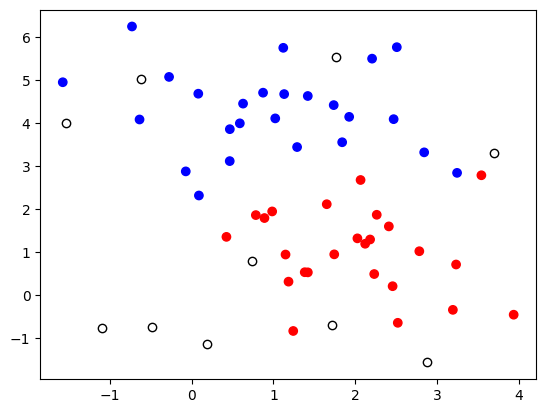

In [57]:
X, y = make_blobs(n_samples=50, centers=2, n_features=2, random_state=0, cluster_std=1)

X_new = np.random.uniform(low=X.min(), high=X.max(), size=(10, 2))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr")
plt.scatter(X_new[:, 0], X_new[:, 1], c='white', edgecolors='k')
plt.show()

In [58]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

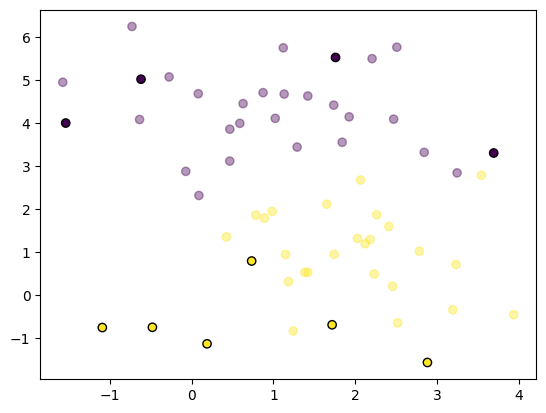

In [59]:
predictions = model.predict(X_new)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.4)
plt.scatter(X_new[:, 0], X_new[:, 1], c=predictions, edgecolors='k')